# Comparison of developed calibration implementation and OpenCV

## Table of Contens
1. [Calibration Data Extraction](#calibration-data-extraction)
2. [Comparsion](#comparsion)
   1. [Calibration](#calibration)
      1. [Given an initial Guess](#given-an-initial-guess)
      2. [Estimating an initail Guess](#estimating-an-initial-guess)
   2. [Undistortion](#undistortion)


In [1]:
%matplotlib widget
import numpy as np
import cv2 as cv
import os
import camera_model as cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import time

## Calibration Data Extraction
This cell extracts the object points and the image points needed for calibration. For this purpose OpenCVs `findChessboardCorners()` and `cornerSubPix` are used, since this semester work focuses on implementing a camera calibration.

In [2]:
# Checkerboard square size
SQUARE_SIZE = 29 # mm

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)*SQUARE_SIZE
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = os.listdir("C:/Program Files/MATLAB/R2022b/toolbox/vision/visiondata/calibration/gopro/")
for imageIdx, fname in enumerate(images):
	img = cv.imread("C:/Program Files/MATLAB/R2022b/toolbox/vision/visiondata/calibration/gopro/"+fname)
	gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
	# Find the chess board corners
	ret, corners = cv.findChessboardCorners(gray, (9,6), None)
	# If found, add object points, image points (after refining them)
	if ret == True:
		objpoints.append(objp)
		corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
		imgpoints.append(corners2)
		# Draw and display the corners
		cv.drawChessboardCorners(img, (9,6), corners2, ret)
		img = cv.resize(img,(int(img.shape[1]*0.4),int(img.shape[0]*0.4)))
		#cv.imshow('img', img)
		#cv.waitKey(0)
		if imageIdx == 8:
			break
cv.destroyAllWindows()

## Comparsion
### Helper Functions

In [3]:
def rot_around_axis(vector, axis, angle):
	"""Helper function to rotate a vector around the normed axis n by the specified angle.

	Args:
		vector (npt.ArrayLike): 3D vector Vector to rotate.
		axis (npt.ArrayLike): 3D normed axis of rotation.
		angle (float): Angle to rotate in rad. The sign is defined by the right hand rule.

	Returns:
		npt.ArrayLike: Rotated vector.
	"""

	# perform a rotation according to rodrigues
	# v' = v*cos(phi)+(axis x v)*sin(phi)+axis * (axis * v)*(1-cos(phi))
	# with phi = norm(axis)

	# as matrix (Rotationmatrix) => faster
	# reuse the cos and sin
	cAng = np.cos(angle)
	sAng = np.sin(angle)
	# reuse the value of 1-cos (shifted cos)
	s_CAng = 1 - cAng

	rotMat = np.array([	[cAng + axis[0]**2*s_CAng, axis[0]*axis[1]*s_CAng - axis[2]*sAng, axis[0]*axis[2]*s_CAng + axis[1]*sAng],
						[axis[0]*axis[1]*s_CAng + axis[2]*sAng, cAng + axis[1]**2*s_CAng, axis[1]*axis[2]*s_CAng - axis[0]*sAng],
						[axis[0]*axis[2]*s_CAng - axis[1]*sAng, axis[1]*axis[2]*s_CAng + axis[0]*sAng, cAng + axis[2]**2*s_CAng]])

	v_rot = np.matmul(rotMat, vector)
	return v_rot

def plot_views(rVecs, tVecs, title = ""):
	# Points of a plane
	p1 = np.array([0,0,0])
	p2 = np.array([30*9,0,0])
	p3 = np.array([30*9,30*6,0])
	p4 = np.array([0,30*6,0])

	fig = plt.figure()
	ax = Axes3D(fig, auto_add_to_figure=False)
	fig.add_axes(ax)
	x = np.array([100,100,-100,-100])
	y = np.array([100,-100,-100,100])
	z = np.array([0,0,0,0])

	verts = [list(zip(x, y, z))]
	collection = Poly3DCollection(verts, linewidths=2, alpha=0.5)
	face_color = [1, 0, 0]
	edge_color = [0,0,0]
	collection.set_facecolor(face_color)
	collection.set_edgecolor(edge_color)
	ax.add_collection3d(collection)


	for viewIdx in range(0,len(rVecs)):
		rVec = rVecs[viewIdx].reshape(3,)
		tVec = tVecs[viewIdx].reshape(3,)
		#rVec = np.array([np.pi*2, 0,0])
		axis = rVec/np.linalg.norm(rVec)
		angle = np.linalg.norm(rVec)
		p1_rot = rot_around_axis(p1,axis,angle)+tVec
		p2_rot = rot_around_axis(p2,axis,angle)+tVec
		p3_rot = rot_around_axis(p3,axis,angle)+tVec
		p4_rot = rot_around_axis(p4,axis,angle)+tVec
		
		x = np.array([p1_rot[0],p2_rot[0],p3_rot[0],p4_rot[0],p1_rot[0]])
		y = np.array([p1_rot[1],p2_rot[1],p3_rot[1],p4_rot[1],p1_rot[1]])
		z = np.array([p1_rot[2],p2_rot[2],p3_rot[2],p4_rot[2],p1_rot[2]])

		verts = [list(zip(x, y, z))]
		collection = Poly3DCollection(verts,linewidths=2,alpha=0.2)
		face_color = [0, 0, 1]
		edge_color = [0,0,0]
		collection.set_facecolor(face_color)
		collection.set_edgecolor(edge_color)
		ax.add_collection3d(collection)
	
	# Set the axes labels
	ax.set_xlabel('x')
	ax.set_ylabel('y')
	ax.set_zlabel('z')

	ax.set_xlim([-250,250])
	ax.set_ylim([-250,250])
	ax.set_zlim([0,1500])
	plt.title(title)
	plt.show()

	def plot_per_view_reprojection_error():
		pass

### Calibration
#### Given an initial Guess
By giving the optional input parameters to the function, the given poses and the initial camera matrix are used as an intial guess for the refinement with the Levenberg-Marquardt Algorithm like described in the documentation.

Starting calibration with OpenCV:
Calibration took 0.2088615894317627 s.

Starting calibration with own implementation:
No convergence reached after max iterations [35]!
Final RMS reprojection error: 0.026875675045468478


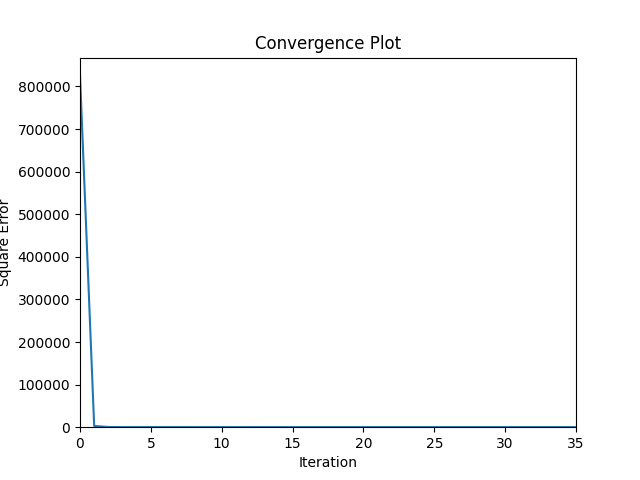

Calibration took 36.240312814712524 s.

Comparison OpenCV and Own Implementation
RMS-Reprojection-Error
OpenCV:		0.5802074658046003
OwnImpl:	0.026875675045468478
Camera Matrix
OpenCV:		[[8.76284051e+02 0.00000000e+00 1.00892486e+03]
 [0.00000000e+00 8.74794296e+02 7.40760123e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
OwnImpl:	[[8.79972831e+02 0.00000000e+00 1.00727716e+03]
 [0.00000000e+00 8.78481196e+02 7.42847458e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients
OpenCV:		k1=-0.27568365087750374, k2=0.11576617106051824, k3=-0.029536143826874257, p1=-0.0003768499115864089, p2=8.744517106737061e-05
OwnImpl:	k1=-0.2853615287011719, k2=0.1351438276059706, k3=-0.041983719127848186, p1=-0.000479343461495059, p2=0.00010582503912586261


In [4]:
# calculate the poses and initial camera matrix
# TODO: .
camera_matrix = np.array([[870,0,1000],[0,870,740],[0,0,1]])
r_vecs = [	np.array([-0.0712924812009836,-0.0292175394495124,0.0255851671102674]),
			np.array([0.360041341702118,0.292270489326601,-0.196294514895238]),
			np.array([-0.21685203707621,0.342032686268539,-0.194822354948762]),
			np.array([0.025707900966097,-0.38269109027857,0.0835269020293139]),
			np.array([0.012599678183883,0.455443059959900,-0.121760978578204]),
			np.array([0.675036205672978,0.106074888811669,-0.037364637599321]),
			np.array([-0.49397086677120,0.003248176783629,0.0475662120021422]),
			np.array([0.379321351852082,0.277671281710087,0.151292570222135]),
			np.array([0.514280045619162,-0.33317568201159,0.0553282501422906])]
t_vecs = [	np.array([-133.570266932208,-82.3866893386230,194.908550346452]),
			np.array([-179.746809682451,-15.5208806619914,241.383487460901]),
			np.array([-184.598770979657,-56.4084249094453,269.570942897015]),
			np.array([-18.1421310225256,-70.1671640289872,157.008019895543]),
			np.array([-162.636947702008,-46.6921260076341,228.102404155863]),
			np.array([-122.945298690088,-15.8962246507799,162.422034456029]),
			np.array([-113.146369394761,-125.398395217610,212.631108594461]),
			np.array([-149.250701390887,-72.3823831078885,173.640576462723]),
			np.array([-49.8586717452160,-24.7843164485865,104.292254178919])]

# compare the parameters
# Calibrate with OpenCV
print("Starting calibration with OpenCV:")
startTime = time.time()
RMSErrorCV, cameraMatrixCV, distortionVecCV, rVecsCV, tVecsCV = cv.calibrateCamera(objpoints, imgpoints, gray.shape, camera_matrix, None, r_vecs, t_vecs)
stopTime = time.time()
print(f"Calibration took {stopTime-startTime} s.\n")

# Calibrate with own implementation
print("Starting calibration with own implementation:")
startTime = time.time()
cam = cm.CameraModel()
RMSError, rVecs, tVecs = cam.calibrate(objpoints,imgpoints,gray.shape,camera_matrix,r_vecs,t_vecs,verbose=True)
cam.save_cam_to_json("test.json")
stopTime = time.time()
print(f"Calibration took {stopTime-startTime} s.\n")

print("Comparison OpenCV and Own Implementation")
print("RMS-Reprojection-Error")
print(f"OpenCV:\t\t{RMSErrorCV}")
print(f"OwnImpl:\t{RMSError}")
print("Camera Matrix")
print(f"OpenCV:\t\t{cameraMatrixCV}")
print(f"OwnImpl:\t{cam.cameraMat}")
print("Distortion Coefficients")
print(f"OpenCV:\t\tk1={distortionVecCV[0,0]}, k2={distortionVecCV[0,1]}, k3={distortionVecCV[0,4]}, p1={distortionVecCV[0,2]}, p2={distortionVecCV[0,3]}")
print(f"OwnImpl:\tk1={cam.distortionVec[0]}, k2={cam.distortionVec[1]}, k3={cam.distortionVec[2]}, p1={cam.distortionVec[3]}, p2={cam.distortionVec[4]}")

#plot_views(rVecsCV,tVecsCV,"Estimated Views OpenCV")
#plot_views(rVecs,tVecs,"Estimated Views OwnImp")

#### Estimating an initial Guess
By not giving the optional input parameters to the function, the poses and initail camera matrix are estimated like described in the dokumentation.

In [1]:
r_vecs = None
t_vecs = None
camera_matrix = None
# Calibrate with OpenCV
print("Starting calibration with OpenCV:")
startTime = time.time()
RMSErrorCV, cameraMatrixCV, distortionVecCV, rVecsCV, tVecsCV = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], camera_matrix, None, r_vecs, t_vecs)
stopTime = time.time()
print(f"Calibration took {stopTime-startTime} s.\n")

# Calibrate with own implementation
print("Starting calibration with own implementation:")
startTime = time.time()
cam = cm.CameraModel()
RMSError, rVecs, tVecs = cam.calibrate(objpoints,imgpoints,gray.shape[0:1],camera_matrix,r_vecs,t_vecs)
stopTime = time.time()
print(f"Calibration took {stopTime-startTime} s.\n")

print("Comparison OpenCV and Own Implementation")
print("RMS-Reprojection-Error")
print(f"OpenCV:\t\t{RMSErrorCV}")
print(f"OwnImpl:\t{RMSError}")
print("Camera Matrix")
print(f"OpenCV:\t\t{cameraMatrixCV}")
print(f"OwnImpl:\t{cam.cameraMat}")
print("Distortion Coefficients")
print(f"OpenCV:\t\tk1={distortionVecCV[0,0]}, k2={distortionVecCV[0,1]}, k3={distortionVecCV[0,4]}, p1={distortionVecCV[0,2]}, p2={distortionVecCV[0,3]}")
print(f"OwnImpl:\tk1={cam.distortionVec[0]}, k2={cam.distortionVec[1]}, k3={cam.distortionVec[2]}, p1={cam.distortionVec[3]}, p2={cam.distortionVec[4]}")

plot_views(rVecsCV,tVecsCV,"Estimated Views OpenCV")
plot_views(rVecs,tVecs,"Estimated Views OwnImp")

Starting calibration with OpenCV:


NameError: name 'time' is not defined

### Undistortion
In this section a calibration sample image is undistorted with OpenCVs `undistort()` using the coefficients determined by OpenCVs `calibrateCamera()`. Following the undistortion is performed by the own implementation found in the CameraModel class `CameraModel.undistortImage()`.

Starting undistortion with OpenCV:
Undistortion took 0.06399273872375488 s.

Starting undistortion with own implementation:
Undistortion took 19.858354091644287 s.



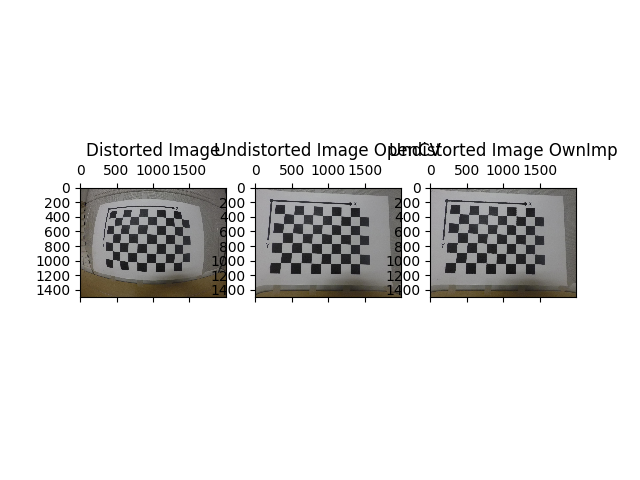

In [6]:
img = cv.imread("C:/Program Files/MATLAB/R2022b/toolbox/vision/visiondata/calibration/gopro/"+images[0])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

print("Starting undistortion with OpenCV:")
startTime = time.time()
undist_imgCV = cv.undistort(img,cameraMatrixCV,distortionVecCV)
stopTime = time.time()
print(f"Undistortion took {stopTime-startTime} s.\n")

print("Starting undistortion with own implementation:")
startTime = time.time()
cam.load_cam_from_json("test.json")
undist_img = cam.undistort_image(img)
stopTime = time.time()
print(f"Undistortion took {stopTime-startTime} s.\n")

fig = plt.figure()
ax = plt.subplot(1,3,1)
ax.set_title("Distorted Image")
ax.matshow(img)
ax = plt.subplot(1,3,2)
ax.set_title("Undistorted Image OpenCV")
ax.matshow(undist_imgCV)
ax = plt.subplot(1,3,3)
ax.set_title("Undistorted Image OwnImp")
ax.matshow(undist_img)